In [1]:
import hist
import json
from coffea import util
import numpy as np

import matplotlib.pyplot as plt
import os

In [16]:
def max_significance(h_sig, h_bkg):

    sigs = h_sig.values()
    bkgs = h_bkg.values()

    cum_sigs_below = []
    cum_bkgs_below = []

    cum_sigs_above = []
    cum_bkgs_above = []

    for i in range(len(sigs)):
        cum_sigs_below += [sum(sigs[:i])]
        cum_bkgs_below += [sum(bkgs[:i])]

        cum_sigs_above += [sum(sigs[i:])]
        cum_bkgs_above += [sum(bkgs[i:])]

    significance_below = np.nan_to_num(cum_sigs_below/np.sqrt(cum_bkgs_below))
    significance_above = np.nan_to_num(cum_sigs_above/np.sqrt(cum_bkgs_above))

    significances = np.sqrt(np.square(significance_below) + np.square(significance_above) )
    print(significances)
    
    return np.nanmax(significances)

In [3]:
with open('xsec.json') as f:
    xs = json.load(f)
        
with open('pmap.json') as f:
    pmap = json.load(f)

with open('lumi.json') as f:
    lumis = json.load(f)

In [4]:
h_ggf = util.load("coffea/ggF.coffea")[0]
#h_ggf['GluGluHToBB']

In [5]:
for key, hist in h_ggf['GluGluHToBB'].items():
    #print(h_ggf['GluGluHToBB'][key])
    if key == 'sumw':
        continue
    h_ggf['GluGluHToBB'][key] *= xs['GluGluHToBB'] * 1000 * lumis["2018"] / h_ggf['GluGluHToBB']['sumw']
    #print(h_ggf['GluGluHToBB'][key])

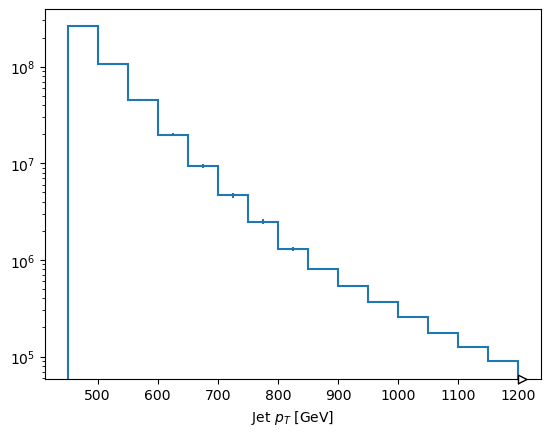

In [13]:
h_qcd = {'TotalQCD':{}}

qcd_slices = ["Pt1000to1400",
              "Pt1400to1800",
              "Pt1800to2400",
              "Pt2400to3200",
              "Pt3200toInf",
              "Pt300to470",
              "Pt470to600",
              "Pt600to800",
              "Pt800to1000"
             ]

# Loop over the histograms (they have the same names as for ggF)
for hname in h_ggf['GluGluHToBB'].keys():

    # Skip sumw because it's not a histogram
    if hname == 'sumw':
        continue

    # Loop over all of the QCD slices
    for s in qcd_slices:

        # Read the histograms from one slice
        h = util.load("coffea/QCD_"+s+".coffea")[0]
        proc = list(h.keys())[0]

        h_qcd[proc] = {}
        h_qcd[proc][hname] = h[proc][hname]
        
        # Scale it! Use string.replace for some funny business with the name of the pT slice
        h_qcd[proc][hname] *= xs[proc.replace("Pt_","PT")] * 1000 * lumis["2018"] / h[proc]['sumw']

    # Add each slice to the total
    h_qcd['TotalQCD'][hname] = sum([h_qcd["QCD_" +proc.replace("Pt","Pt_")][hname] for proc in qcd_slices])

# Sanity check: Draw the pT distribution and make sure it is smoothly falling
h_qcd['TotalQCD']['ExampleHistogram'][{'eta':sum,'msoftdrop':sum,'n2':sum}].plot1d();
plt.yscale('log')

/tmp/ipykernel_3317648/1464255299.py:19: RuntimeWarning: invalid value encountered in divide
  significance_below = np.nan_to_num(cum_sigs_below/np.sqrt(cum_bkgs_below))
/tmp/ipykernel_3317648/1464255299.py:20: RuntimeWarning: invalid value encountered in divide
  significance_above = np.nan_to_num(cum_sigs_above/np.sqrt(cum_bkgs_above))


[0.76718877 0.77060665 0.76765235 0.782382   0.76978837 0.76718877
 0.76718877 0.76718877 0.76718877 0.76718877]


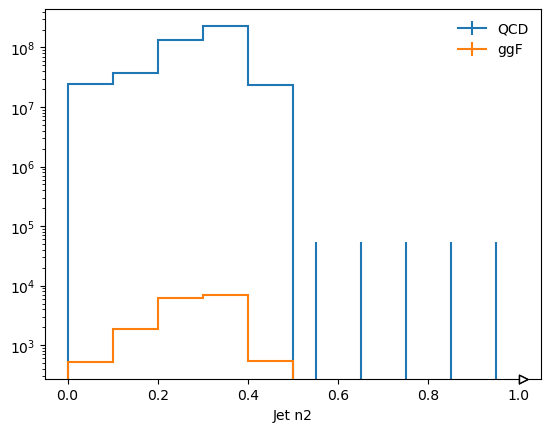

In [17]:
# Choose a set of parameters 
# ExampleHistogram = default, beta = 0, zcut = 0.10
h_bkg = h_qcd['TotalQCD']['ExampleHistogram'][{'eta':sum,'msoftdrop':sum,'pt':sum}]
h_sig = h_ggf['GluGluHToBB']['ExampleHistogram'][{'eta':sum,'msoftdrop':sum,'pt':sum}]

# Get the significance
max_significance(h_sig,h_bkg)

# N2 plot:
h_bkg.plot1d(label='QCD');
h_sig.plot1d(label='ggF');

plt.legend(frameon=False);
plt.yscale('log')